In [31]:
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
from sktime.forecasting.theta import ThetaForecaster
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series
import pandas as pd
import numpy as np
import mplcyberpunk
import matplotlib.pyplot as plt

# Set the styling for our plot later on
plt.style.use("cyberpunk")
plt.rcParams["figure.facecolor"] = "#000000"
plt.rcParams["axes.facecolor"] = "#000000"

# input file
csv_file_name = "./pollution_data.csv"
# columns we want to forecast
target_columns = ["pollution", "dew", "temp", "press", "wnd_spd", "snow", "rain"]

In [24]:
# Load the data
df = pd.read_csv(csv_file_name)

# Convert date column to date just in case
df["date"] = pd.to_datetime(df["date"])

# Get the month and year
df["month"] = df["date"].dt.month
df["year"] = df["date"].dt.year

In [87]:
def create_forecast_for_target(df: pd.DataFrame, target_column: str):
    # Get the only columns we care about
    df = df[["year", "month", target_column]]

    if len(df[df[target_column] < 0]) > 0:
        print(f"Target '{target_column}' contained negative values, skipping . . .")
        return

    # Group by year and month
    data = df.groupby(["year", "month"])[target_column].mean().reset_index()
    # Create a period column that is a Year-Month timeseries
    # Period
    # 0     2010-01
    # 1     2010-02
    # 2     2010-03
    # 3     2010-04
    # 4     2010-05
    # 5     2010-06
    # 6     2010-07
    # 7     2010-08
    # 8     2010-09
    # . . . . 
    data["period"] = pd.to_datetime(
            data.apply(lambda x: f"{int(x.year)}-{int(x.month)}", axis=1)
        ).dt.to_period("M")

    # Set the index of our dataframe to be this timeseries rather than a number
    data.index = data["period"]

    # Drop the columns we don't need.
    # We only need the Year-Month timeseries and the value we want to look at
    data = data.drop(columns=["period", "year", "month"])

    if data[target_column].min() == 0:
        print(f"Target '{target_column}' contained values <= 0, adjusting . . .")
        data[target_column] = data[target_column].map(lambda x: x if x > 0 else 0.001)

    # Get our train and test data
    train, test = temporal_train_test_split(data, train_size=0.95)
    # Create our forecaster (model)
    # sp tells the model how to split the data over the year.
    # year / 12 = months
    forecaster = ThetaForecaster(sp=12)
    # Train the forecaster on our training data
    print(f"Fitting for the target '{target_column}' . . .")
    forecaster.fit(train)

    # Create a timeseries to represent the range we want to predict
    future_timeseries = pd.period_range(start="2015-01-01", end="2016-01-01", freq="M")
    # Create a forecast horizon based on this range
    forecast_horizon = ForecastingHorizon(values=future_timeseries, is_relative=False)
    # Using the forecast horizon range we created, predict the values
    pred = forecaster.predict(forecast_horizon)

    # Plot the orginal data and predicitons
    figure = plot_series(
        data,
        pred,
        title=f"Predicted Data against Truth - {target_column.capitalize()}",
        x_label="Date",
        y_label=f"{target_column.capitalize()} Level",
        labels=["Truth", "Predicted"],
        colors=["C0", "yellow"],
        markers=[None, None]
    )[0]

    # Make the chart Neon (not needed)
    mplcyberpunk.make_lines_glow(
        ax=figure.axes[0],
        n_glow_lines=20,
        diff_linewidth=1.01,
        alpha_line=0.4
    )


Fitting for the target 'pollution' . . .
Target 'dew' contained negative values, skipping . . .
Target 'temp' contained negative values, skipping . . .
Fitting for the target 'press' . . .
Fitting for the target 'wnd_spd' . . .
Target 'snow' contained values <= 0, adjusting . . .
Fitting for the target 'snow' . . .
Target 'rain' contained values <= 0, adjusting . . .
Fitting for the target 'rain' . . .


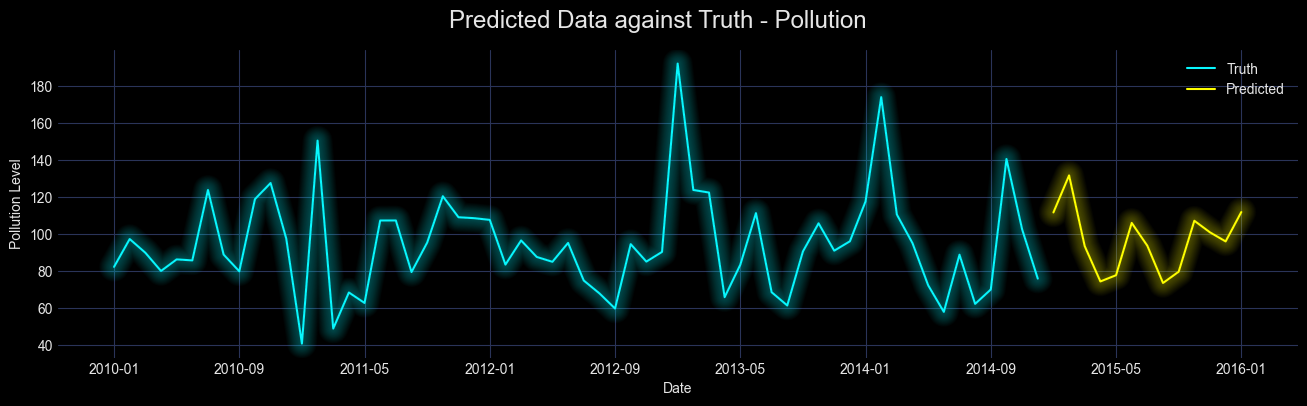

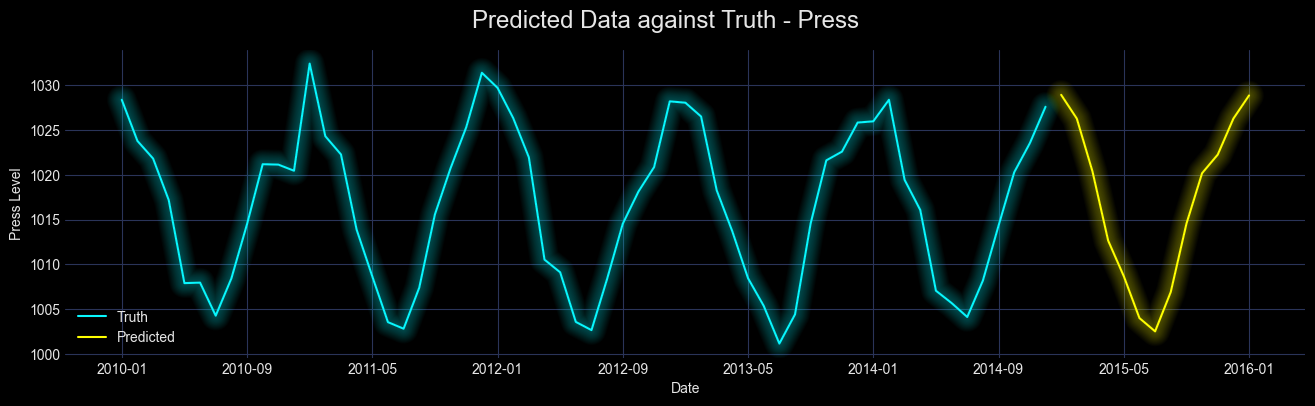

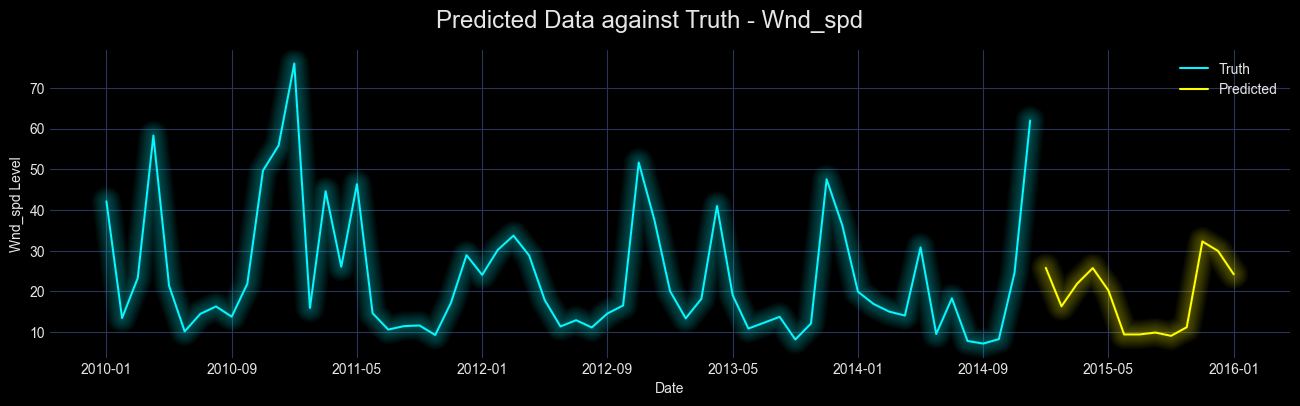

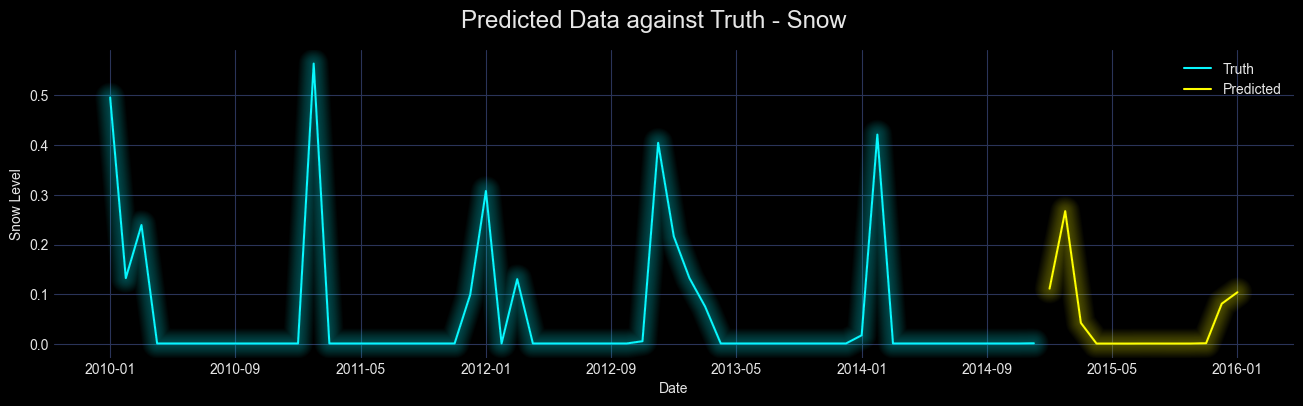

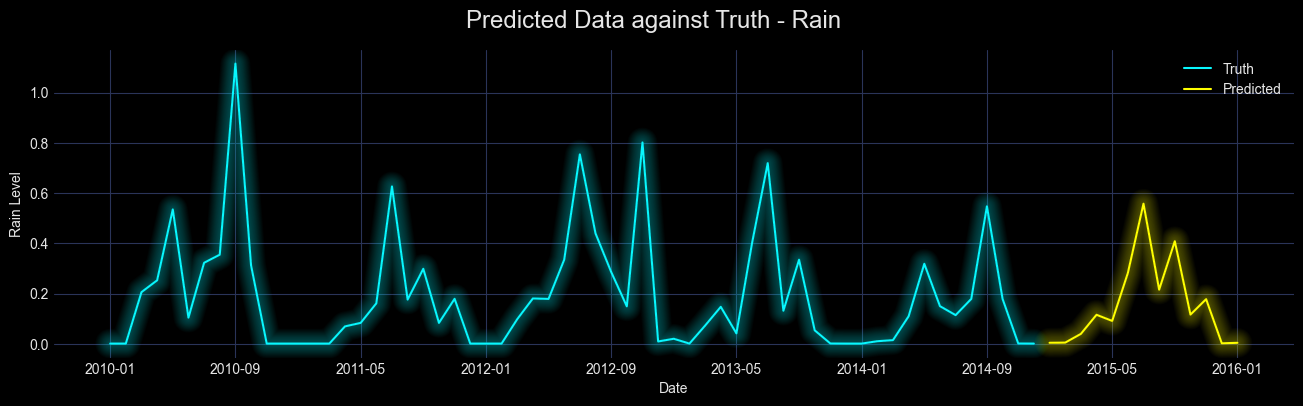

In [88]:
for column in target_columns:
    create_forecast_for_target(df=df, target_column=column)